[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

# State

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [13]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [9]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Reducers

Now, we have a minor problem! 

As we discussed, each node will return a new value for our state key `messages`.

But, this new value [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.
 
As our graph runs, we want to **append** messages to our `messages` state key.
 
We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.
 
But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [25]:
from langchain_core.messages import AnyMessage
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

class MyMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)!

`MessagesState` is defined: 

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects 
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [15]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [16]:
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Model"),
    HumanMessage(content="I'm looking for information on marine biology.", name="Lance"),
    AIMessage(content=f"Great, what would you like to learn about.", name="Model")
]

# New message to add
new_message = HumanMessage(content=f"I want to learn about the best place to see turtles in the Cyprus.", name="Lance")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='be171ec7-b43c-4848-93c5-07441961d610'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='db8fd3a2-171b-4a67-af34-ce9790dea67c'),
 AIMessage(content='Great, what would you like to learn about.', additional_kwargs={}, response_metadata={}, name='Model', id='2f1e1af0-b573-4d44-aefc-6bf0e0e371a5'),
 HumanMessage(content='I want to learn about the best place to see turtles in the Cyprus.', additional_kwargs={}, response_metadata={}, name='Lance', id='8d5a8e0a-34e5-4878-9af5-a3e977181a37')]

LangGraph has prebuilt state with messages whoch calles MessagesState

## Graph with messages

Now, lets use `MessagesState` with a graph.

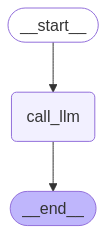

In [19]:
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
llm = ChatOpenAI(model="gpt-4o", temperature=0)

def call_llm(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("call_llm", call_llm)
builder.add_edge(START, "call_llm")
builder.add_edge("call_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [22]:
state = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in state['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


In [23]:
humman_input = input(f"{state['messages'][-1].content}: ")
state["messages"].append(HumanMessage(content=humman_input))

In [24]:
state = graph.invoke(state)
for m in state['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?
================================ Human Message =================================

What is the capital of Cyprus
================================== Ai Message ==================================

The capital of Cyprus is Nicosia.


### Task 1
Make infinite chat graph with human in the loop